In [33]:
import torch
import numpy as np
import time
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import csv
import pandas as pd
import skfuzzy as fuzz
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split

In [34]:
dataset = pd.read_csv('xAPI-Edu-Data.csv')

In [35]:
dataset.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


In [36]:
dataset.describe(include='all')

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
count,480,480,480,480,480,480,480,480,480,480.000000,480.000000,480.000000,480.000000,480,480,480,480
unique,2,14,14,3,10,3,12,2,2,NaN,NaN,NaN,NaN,2,2,2,3
top,M,KW,KuwaIT,MiddleSchool,G-02,A,IT,F,Father,NaN,NaN,NaN,NaN,Yes,Good,Under-7,M
freq,305,179,180,248,147,283,95,245,283,NaN,NaN,NaN,NaN,270,292,289,211
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.775000,54.797917,37.918750,43.283333,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.779223,33.080007,26.611244,27.637735,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.750000,20.000000,14.000000,20.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,65.000000,33.000000,39.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.000000,84.000000,58.000000,70.000000,NaN,NaN,NaN,NaN


In [37]:
imp_features = dataset.drop(['gender', 'NationalITy', 'Semester', 'PlaceofBirth', 'GradeID', 'Topic', 'SectionID', 'Relation'], axis=1)
stage_mapping = {"lowerlevel":0, "MiddleSchool":0.5, "HighSchool":1}
survey_mapping = {"No":0, "Yes":1}
satisfaction_mapping = {"Bad":0, "Good":1}
absence_mapping = {"Under-7":0, "Above-7":1}
class_mapping = {"L":0, "M":1, "H":2}
numeric_features = imp_features
numeric_features['StageID'] = imp_features['StageID'].map(stage_mapping)
numeric_features['ParentAnsweringSurvey'] = imp_features['ParentAnsweringSurvey'].map(survey_mapping)
numeric_features['ParentschoolSatisfaction'] = imp_features['ParentschoolSatisfaction'].map(satisfaction_mapping)
numeric_features['StudentAbsenceDays'] = imp_features['StudentAbsenceDays'].map(absence_mapping)
numeric_features['Class'] = imp_features['Class'].map(class_mapping)

In [38]:
numeric_features.describe(include='all')

,StageID,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.327083,46.775000,54.797917,37.918750,43.283333,0.562500,0.608333,0.397917,1.031250
std,0.301866,30.779223,33.080007,26.611244,27.637735,0.496596,0.488632,0.489979,0.748738
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,15.750000,20.000000,14.000000,20.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,50.000000,65.000000,33.000000,39.000000,1.000000,1.000000,0.000000,1.000000
75%,0.500000,75.000000,84.000000,58.000000,70.000000,1.000000,1.000000,1.000000,2.000000
max,1.000000,100.000000,99.000000,98.000000,99.000000,1.000000,1.000000,1.000000,2.000000


In [39]:
data_np_array = numeric_features.values
print(data_np_array.shape)
X1 = data_np_array[:,1:5]
X2 = np.concatenate((data_np_array[:,0:1],data_np_array[:,5:8]),axis=1)
Y = data_np_array[:,data_np_array.shape[1]-1:data_np_array.shape[1]]

(480, 9)


In [40]:
print(X1.shape)
print(X2.shape)
print(Y.shape)

(480, 4)
(480, 4)
(480, 1)


0.2


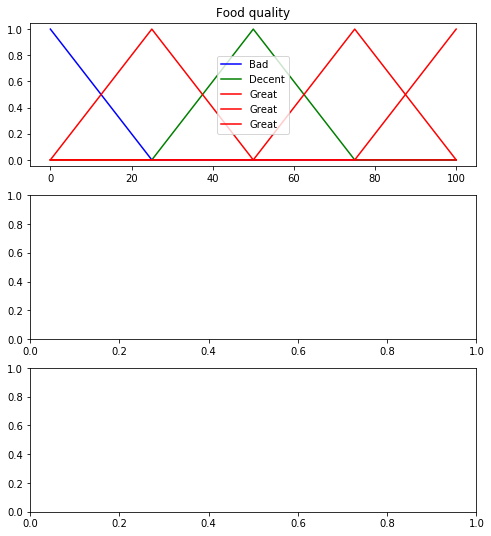

In [41]:
rng = np.arange(0, 101, 1)

vlo = fuzz.trimf(rng, [0, 0, 25])
lo = fuzz.trimf(rng, [0, 25, 50])
md = fuzz.trimf(rng, [25, 50, 75])
hi = fuzz.trimf(rng, [50, 75, 100])
vhi = fuzz.trimf(rng, [75, 100, 100])

level_lo = fuzz.interp_membership(rng, vhi, 80)
print (level_lo)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(rng, vlo, 'b', linewidth=1.5, label='Bad')
ax0.plot(rng, md, 'g', linewidth=1.5, label='Decent')
ax0.plot(rng, hi, 'r', linewidth=1.5, label='Great')
ax0.plot(rng, vhi, 'r', linewidth=1.5, label='Great')
ax0.plot(rng, lo, 'r', linewidth=1.5, label='Great')
ax0.set_title('Food quality')
ax0.legend()
plt.show()

In [42]:
dataSize=480
x=np.zeros((dataSize,20))
for i in range(dataSize):
    for j in range(4):
        x[i,j*5]=fuzz.interp_membership(rng, vlo, X1[i,j])
        x[i,j*5+1]=fuzz.interp_membership(rng, lo, X1[i,j])
        x[i,j*5+2]=fuzz.interp_membership(rng, md, X1[i,j])
        x[i,j*5+3]=fuzz.interp_membership(rng, hi, X1[i,j])
        x[i,j*5+4]=fuzz.interp_membership(rng, vhi, X1[i,j])

In [43]:
print (x.shape)
X=np.concatenate((x,X2),axis=1)
print (X.shape)

(480, 20)
(480, 24)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)
y_train= torch.squeeze(y_train,dim=1)
y_test= torch.squeeze(y_test,dim=1)
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)
print(y_train)

torch.Size([384, 24])
torch.Size([96, 24])
torch.Size([384])
torch.Size([96])
tensor([1., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 1., 1., 0., 2., 0., 0., 1.,
        2., 0., 1., 0., 2., 0., 1., 2., 2., 1., 2., 2., 1., 1., 1., 0., 1., 0.,
        2., 0., 1., 1., 1., 1., 1., 2., 1., 2., 1., 0., 1., 2., 1., 2., 0., 1.,
        1., 1., 0., 2., 0., 1., 2., 2., 2., 0., 1., 1., 1., 2., 2., 1., 1., 1.,
        1., 2., 1., 1., 1., 2., 1., 0., 2., 2., 1., 1., 0., 0., 0., 2., 2., 0.,
        1., 1., 0., 2., 1., 1., 2., 1., 0., 1., 1., 2., 2., 0., 2., 2., 1., 1.,
        1., 0., 1., 2., 0., 0., 1., 1., 1., 2., 2., 0., 0., 0., 2., 1., 0., 0.,
        1., 0., 0., 2., 0., 2., 1., 2., 2., 0., 0., 1., 2., 2., 0., 0., 0., 0.,
        0., 0., 0., 0., 2., 2., 2., 2., 1., 1., 2., 0., 1., 0., 2., 1., 2., 0.,
        1., 2., 0., 2., 1., 1., 1., 1., 0., 2., 0., 0., 1., 1., 1., 1., 2., 0.,
        1., 1., 2., 1., 2., 2., 2., 1., 2., 0., 2., 0., 2., 1., 2., 1., 0., 0.,
        1., 2., 1., 0., 2., 2., 1., 1., 0.

In [45]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder=nn.Linear(24,8)
        self.decoder=nn.Linear(8,24)
        self.l1=nn.Linear(8,64)
        self.l2=nn.Linear(64,3)
        self.soft=nn.Softmax()
    def forward(self, x):
        x1=self.encoder(x)
        x=self.decoder(x1)
        y=self.l1(x1)
        y=self.l2(y)
        y=self.soft(y)
        return x,y

In [46]:
class test(nn.Module):
    def __init__(self):
        super(test, self).__init__()
        self.encoder=nn.Sequential(
            nn.Linear(24,8),
        )
        
        self.decoder=nn.Sequential(
            nn.Linear(8,24),
        )
        
        self.classify = nn.Sequential(
            nn.Linear(8,32),
            nn.Linear(32,3),
            nn.Softmax(),
        )
        
    def forward(self, x):
        x1=self.encoder(x)
        x=self.decoder(x1)
        y=self.classify(x1)
        return x,y

In [47]:
x=torch.tensor(torch.rand(24))
net=test()
optimizer = optim.Adam(net.parameters(), lr=0.1)
y1,y2= net(Variable(x))
print(y1)
print(y2)

tensor([-0.2429,  0.2245, -0.1353, -0.2525,  0.4698, -0.2859, -0.2237, -0.5105,
        -0.0532,  0.4290,  0.4926,  0.4459,  0.3591,  0.3535,  0.0139,  0.2683,
         0.3400, -0.0784, -0.1007,  0.4283,  0.1846, -0.3000,  0.0965, -0.3021],
       grad_fn=<AddBackward0>)
tensor([0.3202, 0.3800, 0.2997], grad_fn=<SoftmaxBackward>)


/home/sid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


ORIGINAL LABELS :  tensor([0., 1., 1., 2., 2., 2., 0., 1.])
LABELS :  tensor([0, 1, 1, 2, 2, 2, 0, 1])
ORIGINAL LABELS :  tensor([1., 1., 0., 0., 1., 1., 1., 2.])
LABELS :  tensor([1, 1, 0, 0, 1, 1, 1, 2])
ORIGINAL LABELS :  tensor([2., 1., 0., 0., 2., 1., 2., 0.])
LABELS :  tensor([2, 1, 0, 0, 2, 1, 2, 0])
ORIGINAL LABELS :  tensor([1., 1., 0., 0., 0., 1., 1., 1.])
LABELS :  tensor([1, 1, 0, 0, 0, 1, 1, 1])
ORIGINAL LABELS :  tensor([1., 0., 2., 1., 1., 1., 0., 2.])
LABELS :  tensor([1, 0, 2, 1, 1, 1, 0, 2])
ORIGINAL LABELS :  tensor([2., 1., 2., 1., 2., 2., 0., 2.])
LABELS :  tensor([2, 1, 2, 1, 2, 2, 0, 2])
ORIGINAL LABELS :  tensor([1., 2., 0., 2., 1., 0., 1., 2.])
LABELS :  tensor([1, 2, 0, 2, 1, 0, 1, 2])
ORIGINAL LABELS :  tensor([0., 1., 0., 1., 1., 1., 2., 0.])
LABELS :  tensor([0, 1, 0, 1, 1, 1, 2, 0])
ORIGINAL LABELS :  tensor([1., 2., 1., 1., 0., 2., 2., 1.])
LABELS :  tensor([1, 2, 1, 1, 0, 2, 2, 1])
ORIGINAL LABELS :  tensor([2., 0., 0., 2., 0., 0., 1., 1.])
LABELS :  ten

ORIGINAL LABELS :  tensor([1., 2., 1., 1., 0., 2., 0., 1.])
LABELS :  tensor([1, 2, 1, 1, 0, 2, 0, 1])
ORIGINAL LABELS :  tensor([0., 2., 1., 2., 2., 2., 1., 0.])
LABELS :  tensor([0, 2, 1, 2, 2, 2, 1, 0])
ORIGINAL LABELS :  tensor([1., 1., 1., 2., 1., 0., 0., 1.])
LABELS :  tensor([1, 1, 1, 2, 1, 0, 0, 1])
ORIGINAL LABELS :  tensor([0., 2., 2., 1., 0., 2., 2., 1.])
LABELS :  tensor([0, 2, 2, 1, 0, 2, 2, 1])
ORIGINAL LABELS :  tensor([1., 0., 1., 2., 2., 1., 1., 1.])
LABELS :  tensor([1, 0, 1, 2, 2, 1, 1, 1])
ORIGINAL LABELS :  tensor([2., 2., 0., 2., 2., 0., 1., 2.])
LABELS :  tensor([2, 2, 0, 2, 2, 0, 1, 2])
ORIGINAL LABELS :  tensor([0., 1., 2., 1., 2., 0., 1., 0.])
LABELS :  tensor([0, 1, 2, 1, 2, 0, 1, 0])
ORIGINAL LABELS :  tensor([1., 1., 0., 0., 0., 2., 0., 0.])
LABELS :  tensor([1, 1, 0, 0, 0, 2, 0, 0])
ORIGINAL LABELS :  tensor([1., 2., 2., 1., 2., 1., 1., 2.])
LABELS :  tensor([1, 2, 2, 1, 2, 1, 1, 2])
ORIGINAL LABELS :  tensor([2., 0., 1., 2., 0., 0., 0., 0.])
LABELS :  ten

LABELS :  tensor([0, 2, 0, 1, 1, 0, 1, 2])
ORIGINAL LABELS :  tensor([2., 1., 0., 2., 1., 2., 0., 1.])
LABELS :  tensor([2, 1, 0, 2, 1, 2, 0, 1])
ORIGINAL LABELS :  tensor([1., 1., 2., 0., 2., 2., 1., 1.])
LABELS :  tensor([1, 1, 2, 0, 2, 2, 1, 1])
ORIGINAL LABELS :  tensor([1., 2., 0., 1., 0., 1., 0., 0.])
LABELS :  tensor([1, 2, 0, 1, 0, 1, 0, 0])
ORIGINAL LABELS :  tensor([1., 1., 1., 0., 1., 2., 2., 0.])
LABELS :  tensor([1, 1, 1, 0, 1, 2, 2, 0])
ORIGINAL LABELS :  tensor([0., 0., 0., 2., 0., 1., 1., 0.])
LABELS :  tensor([0, 0, 0, 2, 0, 1, 1, 0])
ORIGINAL LABELS :  tensor([2., 0., 1., 0., 1., 2., 1., 0.])
LABELS :  tensor([2, 0, 1, 0, 1, 2, 1, 0])
ORIGINAL LABELS :  tensor([1., 2., 0., 2., 0., 1., 1., 2.])
LABELS :  tensor([1, 2, 0, 2, 0, 1, 1, 2])
ORIGINAL LABELS :  tensor([1., 0., 1., 0., 1., 1., 1., 2.])
LABELS :  tensor([1, 0, 1, 0, 1, 1, 1, 2])
ORIGINAL LABELS :  tensor([0., 2., 0., 0., 1., 2., 1., 1.])
LABELS :  tensor([0, 2, 0, 0, 1, 2, 1, 1])
ORIGINAL LABELS :  tensor([1.,

LABELS :  tensor([2, 1, 2, 1, 0, 2, 1, 0])
ORIGINAL LABELS :  tensor([1., 1., 2., 2., 1., 1., 2., 1.])
LABELS :  tensor([1, 1, 2, 2, 1, 1, 2, 1])
ORIGINAL LABELS :  tensor([2., 0., 1., 0., 0., 2., 1., 1.])
LABELS :  tensor([2, 0, 1, 0, 0, 2, 1, 1])
ORIGINAL LABELS :  tensor([2., 2., 0., 1., 0., 0., 0., 2.])
LABELS :  tensor([2, 2, 0, 1, 0, 0, 0, 2])
ORIGINAL LABELS :  tensor([2., 2., 1., 0., 1., 2., 0., 1.])
LABELS :  tensor([2, 2, 1, 0, 1, 2, 0, 1])
ORIGINAL LABELS :  tensor([1., 2., 1., 0., 1., 1., 1., 1.])
LABELS :  tensor([1, 2, 1, 0, 1, 1, 1, 1])
ORIGINAL LABELS :  tensor([2., 1., 0., 1., 0., 1., 2., 1.])
LABELS :  tensor([2, 1, 0, 1, 0, 1, 2, 1])
ORIGINAL LABELS :  tensor([0., 0., 1., 0., 0., 2., 1., 1.])
LABELS :  tensor([0, 0, 1, 0, 0, 2, 1, 1])
ORIGINAL LABELS :  tensor([1., 1., 0., 2., 1., 1., 0., 0.])
LABELS :  tensor([1, 1, 0, 2, 1, 1, 0, 0])
ORIGINAL LABELS :  tensor([0., 1., 1., 0., 0., 1., 1., 1.])
LABELS :  tensor([0, 1, 1, 0, 0, 1, 1, 1])
ORIGINAL LABELS :  tensor([1.,

ORIGINAL LABELS :  tensor([1., 1., 1., 1., 1., 0., 0., 1.])
LABELS :  tensor([1, 1, 1, 1, 1, 0, 0, 1])
ORIGINAL LABELS :  tensor([0., 1., 2., 1., 0., 0., 1., 0.])
LABELS :  tensor([0, 1, 2, 1, 0, 0, 1, 0])
ORIGINAL LABELS :  tensor([2., 2., 1., 0., 1., 2., 2., 2.])
LABELS :  tensor([2, 2, 1, 0, 1, 2, 2, 2])
ORIGINAL LABELS :  tensor([1., 0., 2., 0., 2., 1., 1., 1.])
LABELS :  tensor([1, 0, 2, 0, 2, 1, 1, 1])
ORIGINAL LABELS :  tensor([1., 1., 0., 2., 2., 1., 0., 0.])
LABELS :  tensor([1, 1, 0, 2, 2, 1, 0, 0])
ORIGINAL LABELS :  tensor([2., 1., 2., 0., 2., 1., 0., 1.])
LABELS :  tensor([2, 1, 2, 0, 2, 1, 0, 1])
ORIGINAL LABELS :  tensor([0., 2., 1., 1., 1., 0., 0., 1.])
LABELS :  tensor([0, 2, 1, 1, 1, 0, 0, 1])
ORIGINAL LABELS :  tensor([2., 2., 2., 1., 0., 0., 2., 2.])
LABELS :  tensor([2, 2, 2, 1, 0, 0, 2, 2])
ORIGINAL LABELS :  tensor([0., 1., 1., 1., 0., 1., 2., 0.])
LABELS :  tensor([0, 1, 1, 1, 0, 1, 2, 0])
ORIGINAL LABELS :  tensor([2., 1., 0., 0., 2., 0., 1., 2.])
LABELS :  ten

ORIGINAL LABELS :  tensor([0., 1., 2., 1., 0., 2., 2., 1.])
LABELS :  tensor([0, 1, 2, 1, 0, 2, 2, 1])
ORIGINAL LABELS :  tensor([1., 2., 1., 1., 2., 1., 2., 1.])
LABELS :  tensor([1, 2, 1, 1, 2, 1, 2, 1])
ORIGINAL LABELS :  tensor([1., 0., 0., 2., 0., 1., 2., 0.])
LABELS :  tensor([1, 0, 0, 2, 0, 1, 2, 0])
ORIGINAL LABELS :  tensor([1., 1., 1., 2., 2., 2., 0., 1.])
LABELS :  tensor([1, 1, 1, 2, 2, 2, 0, 1])
ORIGINAL LABELS :  tensor([1., 0., 2., 2., 2., 2., 2., 0.])
LABELS :  tensor([1, 0, 2, 2, 2, 2, 2, 0])
ORIGINAL LABELS :  tensor([1., 0., 1., 2., 1., 0., 0., 2.])
LABELS :  tensor([1, 0, 1, 2, 1, 0, 0, 2])
ORIGINAL LABELS :  tensor([2., 2., 2., 0., 2., 1., 2., 0.])
LABELS :  tensor([2, 2, 2, 0, 2, 1, 2, 0])
ORIGINAL LABELS :  tensor([0., 2., 0., 1., 0., 1., 2., 1.])
LABELS :  tensor([0, 2, 0, 1, 0, 1, 2, 1])
ORIGINAL LABELS :  tensor([1., 2., 0., 1., 0., 2., 1., 2.])
LABELS :  tensor([1, 2, 0, 1, 0, 2, 1, 2])
ORIGINAL LABELS :  tensor([1., 2., 1., 1., 1., 2., 1., 0.])
LABELS :  ten

ORIGINAL LABELS :  tensor([2., 2., 2., 0., 1., 1., 1., 0.])
LABELS :  tensor([2, 2, 2, 0, 1, 1, 1, 0])
ORIGINAL LABELS :  tensor([0., 2., 0., 1., 2., 0., 2., 1.])
LABELS :  tensor([0, 2, 0, 1, 2, 0, 2, 1])
ORIGINAL LABELS :  tensor([0., 2., 1., 2., 1., 0., 1., 1.])
LABELS :  tensor([0, 2, 1, 2, 1, 0, 1, 1])
ORIGINAL LABELS :  tensor([0., 0., 1., 2., 0., 0., 2., 1.])
LABELS :  tensor([0, 0, 1, 2, 0, 0, 2, 1])
ORIGINAL LABELS :  tensor([1., 1., 1., 0., 2., 0., 0., 0.])
LABELS :  tensor([1, 1, 1, 0, 2, 0, 0, 0])
ORIGINAL LABELS :  tensor([2., 2., 2., 0., 2., 2., 0., 0.])
LABELS :  tensor([2, 2, 2, 0, 2, 2, 0, 0])
ORIGINAL LABELS :  tensor([1., 2., 0., 2., 1., 2., 1., 1.])
LABELS :  tensor([1, 2, 0, 2, 1, 2, 1, 1])
ORIGINAL LABELS :  tensor([1., 2., 1., 0., 1., 0., 0., 2.])
LABELS :  tensor([1, 2, 1, 0, 1, 0, 0, 2])
ORIGINAL LABELS :  tensor([1., 0., 1., 2., 0., 2., 2., 1.])
LABELS :  tensor([1, 0, 1, 2, 0, 2, 2, 1])
ORIGINAL LABELS :  tensor([1., 1., 2., 1., 2., 2., 2., 2.])
LABELS :  ten

LABELS :  tensor([1, 1, 1, 1, 0, 1, 2, 0])
ORIGINAL LABELS :  tensor([0., 0., 1., 1., 0., 2., 0., 1.])
LABELS :  tensor([0, 0, 1, 1, 0, 2, 0, 1])
ORIGINAL LABELS :  tensor([1., 2., 2., 2., 1., 1., 1., 2.])
LABELS :  tensor([1, 2, 2, 2, 1, 1, 1, 2])
ORIGINAL LABELS :  tensor([1., 2., 0., 0., 1., 1., 1., 1.])
LABELS :  tensor([1, 2, 0, 0, 1, 1, 1, 1])
ORIGINAL LABELS :  tensor([2., 0., 2., 1., 1., 1., 0., 0.])
LABELS :  tensor([2, 0, 2, 1, 1, 1, 0, 0])
ORIGINAL LABELS :  tensor([1., 0., 1., 1., 1., 0., 0., 0.])
LABELS :  tensor([1, 0, 1, 1, 1, 0, 0, 0])
ORIGINAL LABELS :  tensor([2., 1., 2., 0., 1., 0., 0., 1.])
LABELS :  tensor([2, 1, 2, 0, 1, 0, 0, 1])
ORIGINAL LABELS :  tensor([1., 1., 2., 2., 1., 0., 2., 2.])
LABELS :  tensor([1, 1, 2, 2, 1, 0, 2, 2])
ORIGINAL LABELS :  tensor([1., 1., 0., 1., 1., 2., 2., 1.])
LABELS :  tensor([1, 1, 0, 1, 1, 2, 2, 1])
ORIGINAL LABELS :  tensor([1., 2., 0., 1., 0., 1., 1., 2.])
LABELS :  tensor([1, 2, 0, 1, 0, 1, 1, 2])
ORIGINAL LABELS :  tensor([1.,

ORIGINAL LABELS :  tensor([1., 2., 1., 1., 0., 1., 1., 2.])
LABELS :  tensor([1, 2, 1, 1, 0, 1, 1, 2])
ORIGINAL LABELS :  tensor([1., 1., 1., 2., 0., 0., 1., 1.])
LABELS :  tensor([1, 1, 1, 2, 0, 0, 1, 1])
ORIGINAL LABELS :  tensor([1., 2., 1., 2., 1., 1., 0., 1.])
LABELS :  tensor([1, 2, 1, 2, 1, 1, 0, 1])
ORIGINAL LABELS :  tensor([1., 1., 2., 0., 2., 1., 1., 1.])
LABELS :  tensor([1, 1, 2, 0, 2, 1, 1, 1])
ORIGINAL LABELS :  tensor([0., 1., 1., 0., 1., 0., 0., 2.])
LABELS :  tensor([0, 1, 1, 0, 1, 0, 0, 2])
ORIGINAL LABELS :  tensor([0., 0., 0., 1., 0., 2., 2., 0.])
LABELS :  tensor([0, 0, 0, 1, 0, 2, 2, 0])
ORIGINAL LABELS :  tensor([0., 1., 1., 0., 2., 1., 1., 1.])
LABELS :  tensor([0, 1, 1, 0, 2, 1, 1, 1])
ORIGINAL LABELS :  tensor([2., 2., 0., 0., 2., 1., 1., 2.])
LABELS :  tensor([2, 2, 0, 0, 2, 1, 1, 2])
ORIGINAL LABELS :  tensor([1., 1., 1., 1., 2., 0., 1., 1.])
LABELS :  tensor([1, 1, 1, 1, 2, 0, 1, 1])
ORIGINAL LABELS :  tensor([1., 2., 1., 2., 2., 1., 2., 1.])
LABELS :  ten

LABELS :  tensor([1, 1, 1, 0, 1, 0, 0, 1])
ORIGINAL LABELS :  tensor([1., 2., 1., 2., 1., 1., 1., 1.])
LABELS :  tensor([1, 2, 1, 2, 1, 1, 1, 1])
ORIGINAL LABELS :  tensor([1., 2., 2., 0., 1., 1., 2., 1.])
LABELS :  tensor([1, 2, 2, 0, 1, 1, 2, 1])
ORIGINAL LABELS :  tensor([1., 0., 1., 1., 2., 1., 2., 2.])
LABELS :  tensor([1, 0, 1, 1, 2, 1, 2, 2])
ORIGINAL LABELS :  tensor([0., 1., 1., 2., 1., 2., 1., 0.])
LABELS :  tensor([0, 1, 1, 2, 1, 2, 1, 0])
ORIGINAL LABELS :  tensor([1., 1., 1., 2., 2., 2., 0., 1.])
LABELS :  tensor([1, 1, 1, 2, 2, 2, 0, 1])
ORIGINAL LABELS :  tensor([1., 2., 2., 1., 1., 2., 0., 2.])
LABELS :  tensor([1, 2, 2, 1, 1, 2, 0, 2])
ORIGINAL LABELS :  tensor([2., 1., 1., 1., 1., 0., 2., 2.])
LABELS :  tensor([2, 1, 1, 1, 1, 0, 2, 2])
ORIGINAL LABELS :  tensor([1., 2., 2., 2., 0., 2., 1., 2.])
LABELS :  tensor([1, 2, 2, 2, 0, 2, 1, 2])
ORIGINAL LABELS :  tensor([2., 1., 2., 1., 2., 0., 1., 0.])
LABELS :  tensor([2, 1, 2, 1, 2, 0, 1, 0])
ORIGINAL LABELS :  tensor([0.,

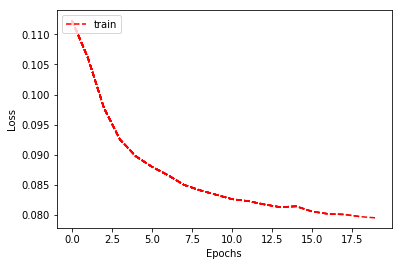

In [48]:
BatchSize=8
iterations = 20
lr=1e-3
w1=0.2
w2=0.8
dataSize2=X_train.shape[0]
criterion2=nn.CrossEntropyLoss()
criterion1=nn.MSELoss()
optimizer= optim.Adam(net.parameters(),lr=lr,betas=(0.9,0.99))

trainloss = []
start = time.time()


for epoch in range(iterations):
    epochStart = time.time()
    runningloss = 0
    net.train(True)   #train start
    rn=torch.randperm(dataSize2)
    X=X_train[rn]
    Y=y_train[rn]
    
    for i in range(0,dataSize2,BatchSize):
        if i+BatchSize>dataSize:
            inputs=X[i:]
            labels=Y[i:]
        else:
            inputs=X[i:i+BatchSize]
            #print(inputs.shape)
            labels=Y[i:i+BatchSize]
            #print(labels.shape)
        
        inputs, labels = Variable(inputs), Variable(labels)
        
        output1,output2 = net(inputs)
        #print(output2.shape)

        print("ORIGINAL LABELS : ",labels)
        loss = w1*criterion1(output1, inputs)+w2*criterion2(output2,labels.long())
        print("LABELS : ",labels.long())
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        runningloss += loss.item()
        
    avgTrainloss = runningloss/dataSize2
    print (avgTrainloss)
    trainloss.append(avgTrainloss)
    
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainloss,'r--',label='train')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')   
      
    epochEnd = time.time()-epochStart
    print('At Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f}; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainloss,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))

In [49]:
def testNet(model, input_tensor, label_tensor, batchsize):

    model.eval()

    testsize = int(input_tensor.shape[0])

    corrects = 0.0
    
    with torch.no_grad():      
    
        for i in range(0, testsize, batchsize):

            if i+batchsize<=testsize:
                inputs = input_tensor[i:i+batchsize]
                labels = label_tensor[i:i+batchsize]

            else:
                inputs = input_tensor[i:]
                labels = label_tensor[i:]

            inputs, labels = Variable(inputs.float()), Variable(labels.long())                      

            # Feed-forward
            output1,output2 = model(inputs)

            _, predicted = torch.max(output2.data, 1)

            corrects += ((predicted==labels).sum(0)).float()

    return corrects/float(testsize)

In [50]:
accuracy=testNet(net, X_test, y_test, 1)

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [51]:
print(accuracy)

tensor(0.7500)
